In [2]:
TEAM_ABBREVS = {
    'ATLANTA HAWKS' : 'ATL',
    'ST. LOUIS HAWKS' : 'SLH',
    'MILWAUKEE HAWKS' : 'MIL',
    'TRI-CITIES BLACKHAWKS' : 'TCB',
    'BOSTON CELTICS' : 'BOS',
    'BROOKLYN NETS' : 'BRK',
    'NEW JERSEY NETS' : 'NJN',
    'CHICAGO BULLS' : 'CHI',
    'CHARLOTTE HORNETS (1988-2004)' : 'CHH',
    'CHARLOTTE HORNETS' : 'CHO',
    'CHARLOTTE BOBCATS' : 'CHA',
    'CLEVELAND CAVALIERS' : 'CLE',
    'DALLAS MAVERICKS' : 'DAL',
    'DENVER NUGGETS' : 'DEN',
    'DETROIT PISTONS' : 'DET',
    'FORT WAYNE PISTONS' : 'FWP',
    'GOLDEN STATE WARRIORS' : 'GSW',
    'SAN FRANCISCO WARRIORS' : 'SFW',
    'PHILADELPHIA WARRIORS' : 'PHI',
    'HOUSTON ROCKETS' : 'HOU',
    'INDIANA PACERS' : 'IND',
    'LOS ANGELES CLIPPERS' : 'LAC',
    'SAN DIEGO CLIPPERS' : 'SDC',
    'BUFFALO BRAVES' : 'BUF',
    'LOS ANGELES LAKERS' : 'LAL',
    'MINNEAPOLIS LAKERS' : 'MIN',
    'MEMPHIS GRIZZLIES' : 'MEM',
    'VANCOUVER GRIZZLIES' : 'VAN',
    'MIAMI HEAT' : 'MIA',
    'MILWAUKEE BUCKS' : 'MIL',
    'MINNESOTA TIMBERWOLVES' : 'MIN',
    'NEW ORLEANS PELICANS' : 'NOP',
    'NEW ORLEANS/OKLAHOMA CITY HORNETS' : 'NOK',
    'NEW ORLEANS HORNETS' : 'NOH',
    'NEW YORK KNICKS' : 'NYK',
    'OKLAHOMA CITY THUNDER' : 'OKC',
    'SEATTLE SUPERSONICS' : 'SEA',
    'ORLANDO MAGIC' : 'ORL',
    'PHILADELPHIA 76ERS' : 'PHI',
    'SYRACUSE NATIONALS' : 'SYR',
    'PHOENIX SUNS' : 'PHO',
    'PORTLAND TRAIL BLAZERS' : 'POR',
    'SACRAMENTO KINGS' : 'SAC',
    'KANSAS CITY KINGS' : 'KCK',
    'KANSAS CITY-OMAHA KINGS' : 'KCK',
    'CINCINNATI ROYALS' : 'CIN',
    'ROCHESTER ROYALS' : 'ROR',
    'SAN ANTONIO SPURS' : 'SAS',
    'TORONTO RAPTORS' : 'TOR',
    'UTAH JAZZ' : 'UTA',
    'NEW ORLEANS JAZZ' : 'NOJ',
    'WASHINGTON WIZARDS' : 'WAS',
    'WASHINGTON BULLETS' : 'WAS',
    'CAPITAL BULLETS' : 'CAP',
    'BALTIMORE BULLETS' : 'BAL',
    'CHICAGO ZEPHYRS' : 'CHI',
    'CHICAGO PACKERS' : 'CHI',
    'ANDERSON PACKERS' : 'AND',
    'CHICAGO STAGS' : 'CHI',
    'INDIANAPOLIS OLYMPIANS' : 'IND',
    'SHEBOYGAN RED SKINS' : 'SRS',
    'ST. LOUIS BOMBERS' : 'SLB',
    'WASHINGTON CAPITOLS' : 'WAS',
    'WATERLOO HAWKS' : 'WAT',
    'SAN DIEGO ROCKETS' : 'SDR',
}

In [5]:
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px
from collections import Counter
from collections import OrderedDict

from basketball_reference_scraper.teams import get_roster, get_team_stats, get_opp_stats, get_roster_stats, get_team_misc
from basketball_reference_scraper.players import get_stats, get_game_logs, get_player_headshot
from basketball_reference_scraper.seasons import get_schedule, get_standings
from basketball_reference_scraper.box_scores import get_box_scores
from basketball_reference_scraper.pbp import get_pbp
from basketball_reference_scraper.shot_charts import get_shot_chart
from basketball_reference_scraper.drafts import get_draft_class

In [4]:
s = get_schedule(2020, playoffs=False)
print(s.columns)
# s = s[(s['HOME'] == 'Portland Trail Blazers') | (s['VISITOR'] == 'Portland Trail Blazers')]
s['HOME_PTS'] = s['HOME_PTS'].astype(int)
s['VISITOR_PTS'] = s['VISITOR_PTS'].astype(int)
s['HOME_WON'] = s.apply(lambda x: x['HOME_PTS'] > x['VISITOR_PTS'], axis=1)
num_home_wins = sum(s['HOME_WON'].astype(int))
prior = num_home_wins / len(s)
marginal = 0
likelihood = 0
for i, row in tqdm(s.iterrows(), total=s.shape[0]):
    # print(row['VISITOR'], row['HOME'])
    pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
    # print(pbp.columns)
    pbp_q4 = pbp[pbp['QUARTER'] == 4]
    home_up_at_q4 = pbp_q4.iloc[0, len(pbp_q4.columns)-1] > pbp_q4.iloc[0, len(pbp_q4.columns)-2]
    if home_up_at_q4:
        marginal += 1
    if home_up_at_q4 and row['HOME_WON']:
        likelihood += 1
likelihood /= num_home_wins
marginal /= len(s)
print(prior, likelihood, marginal)      
print((prior * likelihood) / marginal)

  0%|          | 0/1060 [00:00<?, ?it/s]

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS'], dtype='object')


100%|██████████| 1060/1060 [45:43<00:00,  2.59s/it]

0.5518867924528302 0.7914529914529914 0.5122641509433963
0.8526703499079189


In [7]:
def get_seconds_left(x):
    mins, secs = x.split(':')
    mins = int(mins)
    secs = int(secs.split('.')[0])
    return mins * 60 + secs

s = get_schedule(2020, playoffs=False)
s['HOME_PTS'] = s['HOME_PTS'].astype(int)
s['VISITOR_PTS'] = s['VISITOR_PTS'].astype(int)
s['HOME_WON'] = s.apply(lambda x: x['HOME_PTS'] > x['VISITOR_PTS'], axis=1)
num_close_games = 0
upsetters = []
for i, row in tqdm(s.iterrows(), total=s.shape[0]):
    # print(row['VISITOR'], row['HOME'])
    pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
    pbp['SECONDS_LEFT'] = pbp['TIME_REMAINING'].apply(lambda x: get_seconds_left(x))
    pbp_2mins = pbp[pbp['SECONDS_LEFT'] <= 120]
    score_diff = abs(pbp_2mins.iloc[0, len(pbp_2mins.columns)-2] - pbp_2mins.iloc[0, len(pbp_2mins.columns)-3])
    if score_diff <= 6:
        num_close_games += 1
    home_up_at_2_mins = pbp_2mins.iloc[0, len(pbp_2mins.columns)-2] >= pbp_2mins.iloc[0, len(pbp_2mins.columns)-3]
    if home_up_at_2_mins and not row['HOME_WON']:
        upsetters.append(row['VISITOR'])
    elif not home_up_at_2_mins and row['HOME_WON']:
        upsetters.append(row['HOME'])
print(num_close_games, len(s))

100%|██████████| 1060/1060 [41:46<00:00,  2.36s/it] 

640 1060


In [9]:
Counter(upsetters).most_common()

[('Denver Nuggets', 21),
 ('Boston Celtics', 18),
 ('Houston Rockets', 18),
 ('Los Angeles Lakers', 18),
 ('Los Angeles Clippers', 17),
 ('Toronto Raptors', 16),
 ('Dallas Mavericks', 15),
 ('Indiana Pacers', 15),
 ('Utah Jazz', 15),
 ('Phoenix Suns', 14),
 ('Oklahoma City Thunder', 14),
 ('Milwaukee Bucks', 13),
 ('Chicago Bulls', 13),
 ('Portland Trail Blazers', 12),
 ('Sacramento Kings', 12),
 ('Philadelphia 76ers', 11),
 ('Washington Wizards', 11),
 ('Orlando Magic', 11),
 ('Memphis Grizzlies', 11),
 ('Miami Heat', 10),
 ('Minnesota Timberwolves', 10),
 ('San Antonio Spurs', 10),
 ('Charlotte Hornets', 10),
 ('Brooklyn Nets', 10),
 ('Atlanta Hawks', 10),
 ('New Orleans Pelicans', 9),
 ('New York Knicks', 7),
 ('Detroit Pistons', 7),
 ('Cleveland Cavaliers', 6),
 ('Golden State Warriors', 6)]

In [9]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

s = get_schedule(2020, playoffs=False)
teams = list(s['HOME'].unique())
s['HOME_PTS'] = s['HOME_PTS'].astype(int)
s['VISITOR_PTS'] = s['VISITOR_PTS'].astype(int)
d = {}
for team in tqdm(teams):
    home_games = s[s['HOME'] == team]
    visitor_games = s[s['VISITOR'] == team]
    home_games['TEAM_WON'] = home_games.apply(lambda x: x['HOME_PTS'] > x['VISITOR_PTS'], axis=1)
    visitor_games['TEAM_WON'] = visitor_games.apply(lambda x: x['VISITOR_PTS'] > x['HOME_PTS'], axis=1)
    num_wins = sum(home_games['TEAM_WON'].astype(int)) + sum(visitor_games['TEAM_WON'].astype(int))
    num_games = (len(home_games) + len(visitor_games))
    prior = num_wins / num_games
    marginal = 0
    likelihood = 0
    for i, row in home_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_q4 = pbp[pbp['QUARTER'] == 4]
        team_up_at_q4 = pbp_q4.iloc[0, len(pbp_q4.columns)-1] > pbp_q4.iloc[0, len(pbp_q4.columns)-2]
        if team_up_at_q4:
            marginal += 1
        if team_up_at_q4 and row['TEAM_WON']:
            likelihood += 1
    for i, row in visitor_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_q4 = pbp[pbp['QUARTER'] == 4]
        team_up_at_q4 = pbp_q4.iloc[0, len(pbp_q4.columns)-2] > pbp_q4.iloc[0, len(pbp_q4.columns)-1]
        if team_up_at_q4:
            marginal += 1
        if team_up_at_q4 and row['TEAM_WON']:
            likelihood += 1
    likelihood /= num_wins
    marginal /= num_games   
    posterior = (prior * likelihood) / marginal
    d[team] = {
        'num_wins': num_wins,
        'num_games': num_games,
        'prior': prior,
        'likelihood': likelihood,
        'marginal': marginal,
        'posterior': posterior
    }

100%|██████████| 30/30 [1:48:05<00:00, 216.17s/it]


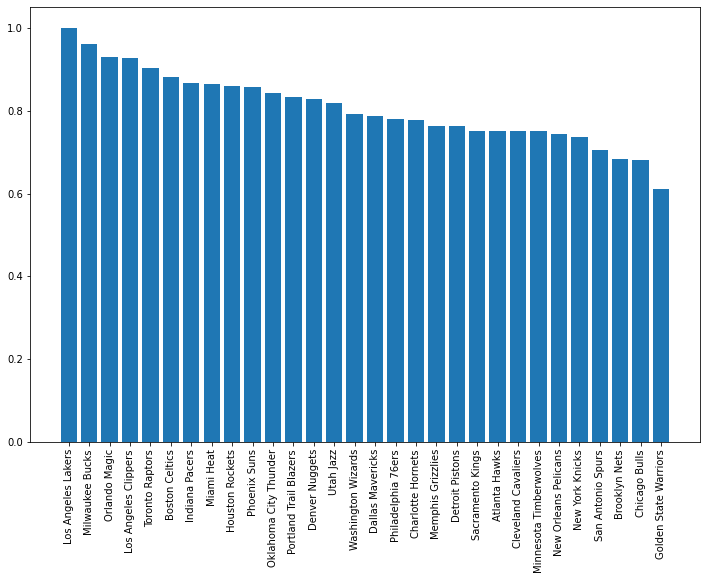

In [15]:
from collections import OrderedDict
sorted_dict = OrderedDict(sorted(d.items(), key=lambda kv: kv[1]['posterior'], reverse=True))
sorted_posteriors = {k: v['posterior'] for k, v in sorted_dict.items()}
fig = plt.figure(figsize=(12,8))
plt.bar(sorted_posteriors.keys(), sorted_posteriors.values())
plt.xticks(rotation=90);

In [33]:
import plotly.express as px
df = pd.DataFrame(d).T.reset_index()
df.columns = ['team', *df.columns[1:]]
fig = px.scatter(df, x='posterior', y='prior', color='team')
fig.update_traces(hovertemplate=' ')

# P(winning | leading at halftime)

In [38]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

s = get_schedule(2020, playoffs=False)
teams = list(s['HOME'].unique())
s['HOME_PTS'] = s['HOME_PTS'].astype(int)
s['VISITOR_PTS'] = s['VISITOR_PTS'].astype(int)
half_dict = {}
for team in tqdm(teams):
    home_games = s[s['HOME'] == team]
    visitor_games = s[s['VISITOR'] == team]
    home_games['TEAM_WON'] = home_games.apply(lambda x: x['HOME_PTS'] > x['VISITOR_PTS'], axis=1)
    visitor_games['TEAM_WON'] = visitor_games.apply(lambda x: x['VISITOR_PTS'] > x['HOME_PTS'], axis=1)
    num_wins = sum(home_games['TEAM_WON'].astype(int)) + sum(visitor_games['TEAM_WON'].astype(int))
    num_games = (len(home_games) + len(visitor_games))
    prior = num_wins / num_games
    marginal = 0
    likelihood = 0
    for i, row in home_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_half = pbp[pbp['QUARTER'] == 3]
        team_up_at_half = pbp_half.iloc[0, len(pbp_half.columns)-1] > pbp_half.iloc[0, len(pbp_half.columns)-2]
        if team_up_at_half:
            marginal += 1
        if team_up_at_half and row['TEAM_WON']:
            likelihood += 1
    for i, row in visitor_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_half = pbp[pbp['QUARTER'] == 3]
        team_up_at_half = pbp_half.iloc[0, len(pbp_half.columns)-2] > pbp_half.iloc[0, len(pbp_half.columns)-1]
        if team_up_at_half:
            marginal += 1
        if team_up_at_half and row['TEAM_WON']:
            likelihood += 1
    likelihood /= num_wins
    marginal /= num_games   
    posterior = (prior * likelihood) / marginal
    half_dict[team] = {
        'num_wins': num_wins,
        'num_games': num_games,
        'prior': prior,
        'likelihood': likelihood,
        'marginal': marginal,
        'posterior': posterior
    }

100%|██████████| 30/30 [1:22:13<00:00, 164.45s/it]


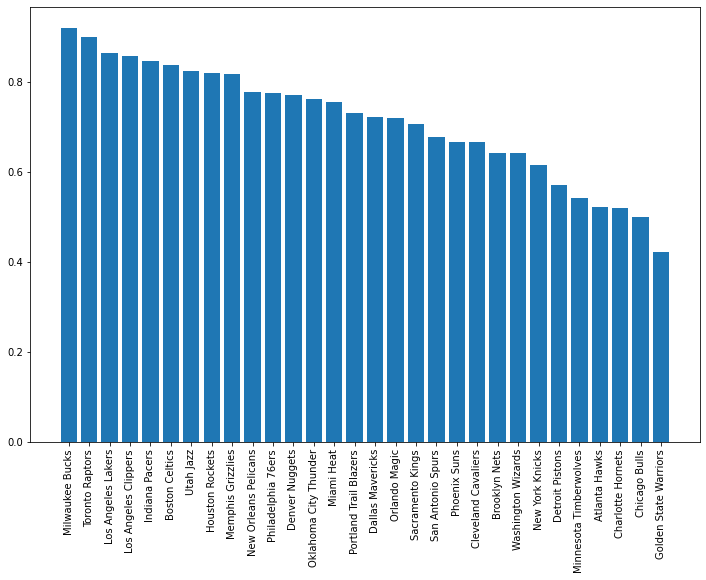

In [40]:
from collections import OrderedDict
sorted_dict = OrderedDict(sorted(half_dict.items(), key=lambda kv: kv[1]['posterior'], reverse=True))
sorted_posteriors = {k: v['posterior'] for k, v in sorted_dict.items()}
fig = plt.figure(figsize=(12,8))
plt.bar(sorted_posteriors.keys(), sorted_posteriors.values())
plt.xticks(rotation=90);

In [39]:
import plotly.express as px
df = pd.DataFrame(half_dict).T.reset_index()
df.columns = ['team', *df.columns[1:]]
fig = px.scatter(df, x='posterior', y='prior', color='team')
fig.update_traces(hovertemplate=' ')

# P(winning | leading after Q1)

In [17]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

s = get_schedule(2020, playoffs=False)
teams = list(s['HOME'].unique())
s['HOME_PTS'] = s['HOME_PTS'].astype(int)
s['VISITOR_PTS'] = s['VISITOR_PTS'].astype(int)
q1_dict = {}
for team in tqdm(teams):
    home_games = s[s['HOME'] == team]
    visitor_games = s[s['VISITOR'] == team]
    home_games['TEAM_WON'] = home_games.apply(lambda x: x['HOME_PTS'] > x['VISITOR_PTS'], axis=1)
    visitor_games['TEAM_WON'] = visitor_games.apply(lambda x: x['VISITOR_PTS'] > x['HOME_PTS'], axis=1)
    num_wins = sum(home_games['TEAM_WON'].astype(int)) + sum(visitor_games['TEAM_WON'].astype(int))
    num_games = (len(home_games) + len(visitor_games))
    prior = num_wins / num_games
    marginal = 0
    likelihood = 0
    for i, row in home_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_q2 = pbp[pbp['QUARTER'] == 2]
        team_up_at_q2 = pbp_q2.iloc[0, len(pbp_q2.columns)-1] > pbp_q2.iloc[0, len(pbp_q2.columns)-2]
        if team_up_at_q2:
            marginal += 1
        if team_up_at_q2 and row['TEAM_WON']:
            likelihood += 1
    for i, row in visitor_games.iterrows():
        # if i == 0:
        #     print(row['VISITOR'], row['HOME'])
        pbp = get_pbp(row['DATE'], TEAM_ABBREVS[row['VISITOR'].upper()], TEAM_ABBREVS[row['HOME'].upper()])
        pbp_q2 = pbp[pbp['QUARTER'] == 2]
        team_up_at_q2 = pbp_q2.iloc[0, len(pbp_q2.columns)-2] > pbp_q2.iloc[0, len(pbp_q2.columns)-1]
        if team_up_at_q2:
            marginal += 1
        if team_up_at_q2 and row['TEAM_WON']:
            likelihood += 1
    likelihood /= num_wins
    marginal /= num_games   
    posterior = (prior * likelihood) / marginal
    q1_dict[team] = {
        'num_wins': num_wins,
        'num_games': num_games,
        'prior': prior,
        'likelihood': likelihood,
        'marginal': marginal,
        'posterior': posterior
    }

100%|██████████| 30/30 [1:31:59<00:00, 184.00s/it]


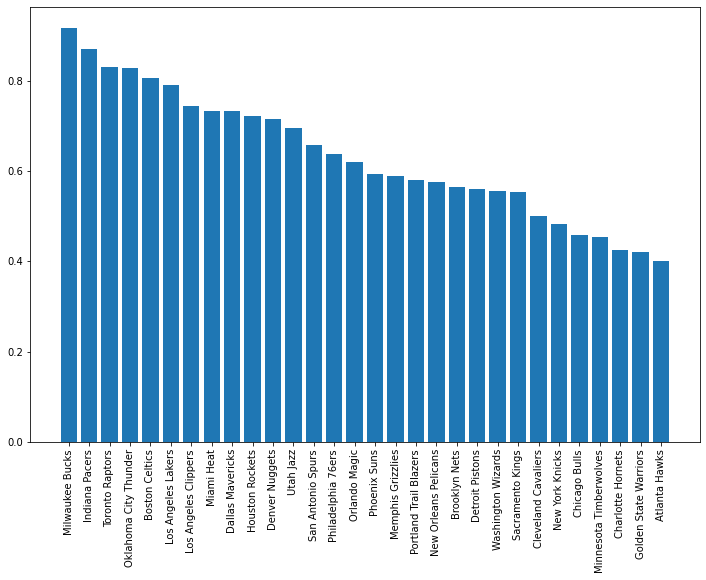

In [19]:
from collections import OrderedDict
sorted_dict = OrderedDict(sorted(q1_dict.items(), key=lambda kv: kv[1]['posterior'], reverse=True))
sorted_posteriors = {k: v['posterior'] for k, v in sorted_dict.items()}
fig = plt.figure(figsize=(12,8))
plt.bar(sorted_posteriors.keys(), sorted_posteriors.values())
plt.xticks(rotation=90);

In [22]:
df = pd.DataFrame(q1_dict).T.reset_index()
df.columns = ['team', *df.columns[1:]]
fig = px.scatter(df, x='posterior', y='prior', color='team')
fig.update_traces(hovertemplate=' ')

In [6]:

s = get_pbp('2020-01-13', 'CHI', 'BOS')
s[s['QUARTER'] == 4]

,QUARTER,TIME_REMAINING,CHICAGO_ACTION,BOSTON_ACTION,CHICAGO_SCORE,BOSTON_SCORE
315,4,11:44.0,NaN,J. Tatum makes 2-pt jump shot from 17 ft (assi...,71,85
316,4,11:44.0,NaN,Shooting foul by C. Hutchison (drawn by J. Tatum),71,85
317,4,11:44.0,NaN,J. Tatum makes free throw 1 of 1,71,86
318,4,11:32.0,T. Young misses 2-pt jump shot from 9 ft,NaN,71,86
319,4,11:29.0,NaN,Defensive rebound by E. Freedom,71,86
...,...,...,...,...,...,...
446,4,1:04.0,NaN,R. Langford makes free throw 2 of 2,96,113
447,4,0:54.0,D. Valentine makes 2-pt jump shot from 15 ft,NaN,98,113
448,4,0:33.0,NaN,V. Poirier misses 2-pt hook shot from 5 ft,98,113
449,4,0:29.0,Defensive rebound by D. Valentine,NaN,98,113


In [65]:
s = get_shot_chart('2020-01-13', 'CHI', 'BOS')['BOS']
s.columns

Index(['x', 'y', 'QUARTER', 'TIME_REMAINING', 'PLAYER', 'MAKE_MISS', 'VALUE',
       'DISTANCE'],
      dtype='object')

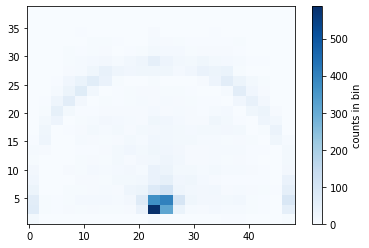

In [96]:
s = shot_df.copy()
s['x_pos'] = s['x'].apply(lambda x: float(x.strip(' ft')))
s['y_pos'] = s['y'].apply(lambda y: float(y.strip(' ft')))
# sns.heatmap(data=s.pivot("x_pos", "y_pos", "hue"))
x = s['x_pos'].to_list()
y = s['y_pos'].to_list()
plt.hist2d(x, y, bins=22, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

In [17]:
from basketball_reference_scraper.injury_report import get_injury_report

s = get_injury_report()
s

,PLAYER,TEAM,DATE,DESCRIPTION,STATUS,INJURY
0,Bogdan BogdanoviÄ‡,ATL,2022-02-14,Bogdanovic is listed as QUESTIONABLE for Tuesd...,Day To Day,Ankle
1,John Collins,ATL,2022-02-12,The Hawks announced that Collins will be sidel...,Out,Foot
2,Delon Wright,ATL,2022-02-14,Wright is listed as QUESTIONABLE for Tuesday's...,Day To Day,Groin
3,Kevin Durant,BRK,2022-01-16,The Nets announced that Durant was diagnosed w...,Out,Knee
4,Joe Harris,BRK,2021-11-29,Nets coach Steve Nash said Harris will have an...,Out,Ankle
...,...,...,...,...,...,...
89,Rudy Gay,UTA,2022-02-14,Gay is out for Monday's (Feb. 14) game against...,Out,Knee
90,Bradley Beal,WAS,2022-02-08,Beal will undergo season ending surgery on his...,Out For Season,Wrist
91,Daniel Gafford,WAS,2022-02-13,Gafford is out for Monday's (Feb. 14) game aga...,Out,Reconditioning
92,Rui Hachimura,WAS,2022-02-14,Hachimura left Monday's (Feb. 14) game and did...,Day To Day,Ankle


In [18]:


df = get_game_logs('Pau Gasol', '2010-01-12', '2010-01-20', playoffs=False)
df

You searched for "Pau Gasol"
7 results found.


,DATE,AGE,TEAM,HOME/AWAY,OPPONENT,RESULT,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GAME_SCORE,+/-
40,2010-01-15,29-193,LAL,HOME,LAC,W (+40),1,30:29,4,10,...,2,6,3,0,3,1,0,20,21.2,+22
42,2010-01-18,29-196,LAL,HOME,ORL,W (+6),1,39:32,8,14,...,7,10,2,1,0,1,4,17,14.4,+7


In [19]:
url = get_player_headshot('Kobe Bryant')
print(url)

You searched for "Kobe Bryant"
4 results found.
https://d2cwpp38twqe55.cloudfront.net/req/202006192/images/players/bryanko01.jpg


In [22]:
df = get_draft_class(2021)
df

,PICK,TEAM,PLAYER,COLLEGE,YEARS,TOTALS_G,TOTALS_MP,TOTALS_PTS,TOTALS_TRB,TOTALS_AST,...,SHOOTING_3P%,SHOOTING_FT%,PER_GAME_MP,PER_GAME_PTS,PER_GAME_TRB,PER_GAME_AST,ADVANCED_WS,ADVANCED_WS/48,ADVANCED_BPM,ADVANCED_VORP
0,1,DET,Cade Cunningham,Oklahoma State,1,43,1363,672,233,221,...,.323,.864,31.7,15.6,5.4,5.1,-0.7,-.026,-2.2,-0.1
1,2,HOU,Jalen Green,NaN,1,41,1241,589,132,97,...,.300,.819,30.3,14.4,3.2,2.4,-0.9,-.036,-5.2,-1.0
2,3,CLE,Evan Mobley,USC,1,49,1667,721,393,124,...,.273,.672,34.0,14.7,8.0,2.5,4.0,.116,0.8,1.2
3,4,TOR,Scottie Barnes,Florida State,1,48,1704,697,361,160,...,.313,.733,35.5,14.5,7.5,3.3,3.6,.102,-0.2,0.8
4,5,ORL,Jalen Suggs,Gonzaga,1,38,1064,473,142,166,...,.234,.770,28.0,12.4,3.7,4.4,-1.2,-.052,-5.1,-0.8
5,6,OKC,Josh Giddey,NaN,1,52,1630,642,402,329,...,.267,.705,31.3,12.3,7.7,6.3,0.9,.025,-1.0,0.4
6,7,GSW,Jonathan Kuminga,NaN,1,46,659,362,129,30,...,.306,.655,14.3,7.9,2.8,0.7,1.5,.109,-2.7,-0.1
7,8,ORL,Franz Wagner,Michigan,1,59,1889,923,272,176,...,.362,.853,32.0,15.6,4.6,3.0,2.9,.073,-1.0,0.5
8,9,SAC,Davion Mitchell,Baylor,1,53,1376,551,125,183,...,.326,.558,26.0,10.4,2.4,3.5,0.2,.007,-3.4,-0.5
9,10,NOP,Ziaire Williams,Stanford,1,38,821,278,67,35,...,.289,.760,21.6,7.3,1.8,0.9,1.0,.060,-4.1,-0.4
